In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import seaborn as sns

from scipy import signal
from scipy.special import kv
sns.set_style("white")

# Spring constants

Tipless cantilever with the following dimensions:

$L$ = 225 $\mu$m, $b$ = 28 $\mu$m, and $t$ = 2 $\mu$m

The spring constants are given by $k_{\text{flex}} = E b t^{3}/4 L^{3}$ and 
$k_{\text{tor}} = G b t^{3}/3 L$, where $E$ and $G$ are the Young's moduli. 

$k_{\text{tor}}/k_{\text{flex}} = (G/E)(4/3)L^{2} = \frac{2}{3(1+\gamma)} \, L^{2}$

In [2]:
E = 169*1e9
gamma = 0.25 # Poisson's ratio
G = 0.5*E/(1+gamma)

L = 225*1e-6
b = 28*1e-6
t_avg = 2*1e-6 #error is about 1 um
t_min = 1*1e-6
t_max = 3*1e-6

k_flex_min = E*b*t_min**3/(4*L**3) # N/m 
k_flex_max = E*b*t_max**3/(4*L**3) # N/m 

k_tor_min = G*b*t_min**3/(3*L)*1e9 # nN m
k_tor_max = G*b*t_max**3/(3*L)*1e9 # nN m

print "Expected flexular spring constant: %.2f to %.2f N/m" %(k_flex_min, k_flex_max)
print "Expected torsional spring constant: %.2f to %.2f nN m/rad" %(k_tor_min, k_tor_max)
print "Expected ratio is %.2e m2" %(k_tor_max/k_flex_max*1e-9)

Expected flexular spring constant: 0.10 to 2.80 N/m
Expected torsional spring constant: 2.80 to 75.71 nN m/rad
Expected ratio is 2.70e-08 m2


# Hydrodynamic function

Information about the hydrodynamic functions for flexular and torsional oscillations can be found in equations 20 of: 

1. J. E. Sader, J. Appl. Phys. 84, 64 (1998)
2. C. P. Green and J. E. Sader, J. Appl. Phys. 92, 6262 (2002)
 
Hydrodynamic functions (gamma), for both flexular (f) and torsional (t) oscillations, have real (r) and imaginary (i) components. Hydrodynamic functions only depend on the Reynolds number of the fluid $Re = \rho \omega b^{2}/4 \eta$. 

For air, $\rho$ = 1.205 kg/m$^{3}$, $\eta$ = 1.821 $\times 10^{-5}$ Pa.s

For water, $\rho$ = 998.19 kg/m$^{3}$, $\eta$ = 1.00 $\times 10^{-3}$ Pa.s

# Flexular hydrodynamic function

Functions for the real and imaginary parts (full and dashed lines) of hydrodynamic function; cf. Fig. 1 of ref[1]. 

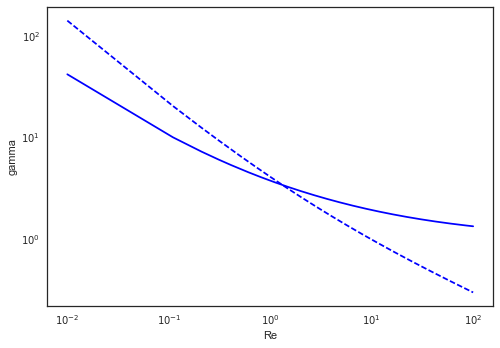

In [3]:
def gamma_f_r(Re): 
    
    tau = np.log10(Re)
    O_r = (0.91324 - 0.48274*tau+0.46842*tau**2-0.12886*tau**3
          + 0.044055*tau**4 - 0.0035117*tau**5 + 0.00069085*tau**6)/(1                                                                
         -0.56964*tau + 0.48690*tau**2 - 0.13444*tau**3
          + 0.045155*tau**4 - 0.0035862*tau**5 + 0.00069085*tau**6) 
        
    O_i = (-0.024134 - 0.029256*tau + 0.016294*tau**2
            -0.00010961*tau**3 + 0.000064577*tau**4 - 0.000044510*tau**5)/(1 
            -0.59702*tau + 0.55182*tau**2 - 0.18357*tau**3
           + 0.079156*tau**4 - 0.014369*tau**5 + 0.0028361*tau**6)
        
    O_complex = O_r + 1j*O_i
    
    gamma_circ_complex = 1 + 4j*kv(1,-1j*np.sqrt(1j*Re))/(np.sqrt(1j*Re)*kv(0,-1j*np.sqrt(1j*Re)))
    gamma_complex = O_complex*gamma_circ_complex
    return np.real(gamma_complex)

def gamma_f_i(Re):
    
    tau = np.log10(Re)
    O_r = (0.91324 - 0.48274*tau+0.46842*tau**2-0.12886*tau**3
          + 0.044055*tau**4 - 0.0035117*tau**5 + 0.00069085*tau**6)/(1                                                                
         -0.56964*tau + 0.48690*tau**2 - 0.13444*tau**3
          + 0.045155*tau**4 - 0.0035862*tau**5 + 0.00069085*tau**6) 
        
    O_i = (-0.024134 - 0.029256*tau + 0.016294*tau**2
            -0.00010961*tau**3 + 0.000064577*tau**4 - 0.000044510*tau**5)/(1 
            -0.59702*tau + 0.55182*tau**2 - 0.18357*tau**3
           + 0.079156*tau**4 - 0.014369*tau**5 + 0.0028361*tau**6)
        
    O_complex = O_r + 1j*O_i
    
    gamma_circ_complex = 1 + 4j*kv(1,-1j*np.sqrt(1j*Re))/(np.sqrt(1j*Re)*kv(0,-1j*np.sqrt(1j*Re)))
    gamma_complex = O_complex*gamma_circ_complex
    return np.imag(gamma_complex)


# Plot the hydrodynamic function 
Re_arr = np.linspace(0.01,100,1000)
gamma_f_r_arr = [gamma_f_r(Re) for Re in Re_arr]
gamma_f_i_arr = [gamma_f_i(Re) for Re in Re_arr]

plt.loglog(Re_arr, gamma_f_r_arr, '-b')
plt.loglog(Re_arr, gamma_f_i_arr, '--b')

plt.xlabel("Re")
plt.ylabel("gamma")

## Torsional hydrodynamic functions

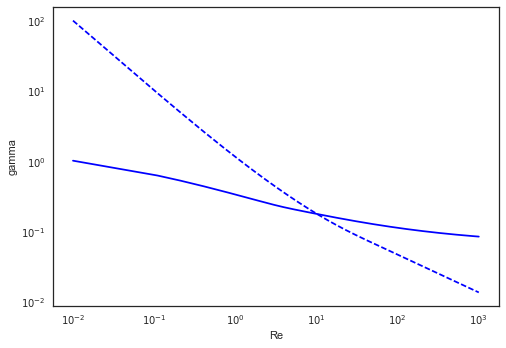

In [4]:
def gamma_t_r(Re): 
    
    tau = np.log10(Re)
    O_r = (4.17950 - 0.25269*tau+2.88308*tau**2-0.08680*tau**3
          + 0.33837*tau**4 - 0.03318*tau**5 + 0.01884*tau**6)/(1                                                                
         -2.27659*tau + 2.10179*tau**2 - 0.11365*tau**3
          + 0.34989*tau**4 - 0.03779*tau**5 + 0.01884*tau**6) 
        
    gamma_real = (5*Re-15*np.log(Re)+8)/(80*(Re + 1))*O_r 
    
    return gamma_real

def gamma_t_i(Re):
    
    tau = np.log10(Re)
    O_i = (0.82494 - 0.67701*tau+0.41150*tau**2-0.16748*tau**3
          + 0.04897*tau**4 + 0.01107*tau**5 + 0.00148*tau**6)/(1                                                                
         -0.72962*tau + 0.40663*tau**2 - 0.16517*tau**3
          + 0.04907*tau**4 + 0.01110*tau**5 + 0.00148*tau**6)
        
    gamma_i =  (0.41/np.sqrt(Re) +  1/Re)*O_i
    return gamma_i



# Plot the hydrodynamic function 
Re_arr = np.linspace(1e-2,1e3,10000)
gamma_t_r_arr = [gamma_t_r(Re) for Re in Re_arr]
gamma_t_i_arr = [gamma_t_i(Re) for Re in Re_arr]

plt.loglog(Re_arr, gamma_t_r_arr, '-b')
plt.loglog(Re_arr, gamma_t_i_arr, '--b')

plt.xlabel("Re")
plt.ylabel("gamma")

# Import Data

In [5]:
file_name = "raw_voltage.csv"  
df = pd.read_csv(file_name, sep=None, skiprows=6, engine='python', 
                 header=None, names=["Time", "Height", "Height (measured & smoothed)",
                                     "Height (measured)", "Lateral Deflection",
                                     "Vertical Deflection", "X Position (Tip)",
                                     "Y Position (Tip)"])
df.head()


,Time,Height,Height (measured & smoothed),Height (measured),Lateral Deflection,Vertical Deflection,X Position (Tip),Y Position (Tip)
0,0.000000,0.000011,NaN,0.000015,-0.137985,7.915163e-08,-0.000005,-0.000005
1,0.000002,0.000011,NaN,0.000015,-0.138854,7.884635e-08,-0.000005,-0.000005
2,0.000003,0.000011,NaN,0.000015,-0.142878,7.724367e-08,-0.000005,-0.000005
3,0.000005,0.000011,NaN,0.000015,-0.139997,7.924067e-08,-0.000005,-0.000005
4,0.000007,0.000011,NaN,0.000015,-0.135470,7.915163e-08,-0.000005,-0.000005


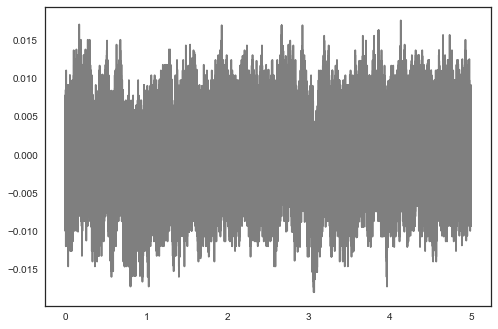

In [6]:
t = df["Time"].values
V_vert = (df["Vertical Deflection"].values/2.294)/(105.27*1e-9) 
V_lat = df["Lateral Deflection"].values

plt.plot(t, V_vert-np.mean(V_vert), alpha=0.5, color='k')
# plt.xlim([0,1])

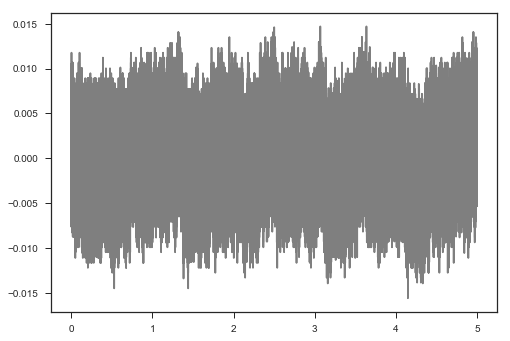

In [7]:
sns.set_style("ticks")
plt.plot(t, V_lat-np.mean(V_lat), alpha=0.5, color='k')


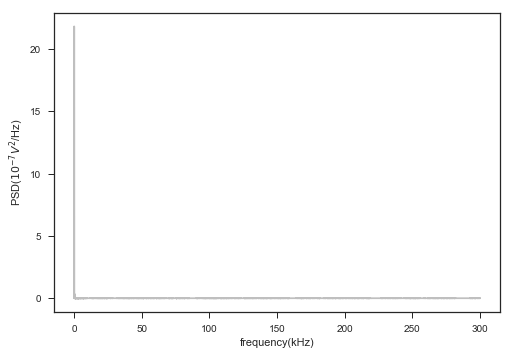

In [8]:
fs = 6e5 # sampling rate

f_lat, P_lat = signal.periodogram(V_lat, fs)
f_vert, P_vert = signal.periodogram(V_vert, fs)

fig_1, ax_1 = plt.subplots()
ax_1.plot(f_vert/1000, P_vert*1e7, alpha=0.5, color='gray')


ax_1.set_xlabel("frequency(kHz)")
ax_1.set_ylabel("PSD($10^{-7} V^{2}$/Hz)")


# Fit data

## Flexular data

In [9]:
from scipy.optimize import curve_fit

# Simple Harmonic Oscillator model
def A_SH(f, f_o, Q, A_dc, A_o):
    return A_dc**2*f_o**4/((f_o**2-f**2)**2 + (f_o*f/Q)**2) + A_o**2

# for air
rho = 1.205
eta = 1.82181e-5 
L = 228*1e-6 
b = 28*1e-6

/Users/Daniel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


Fitted values are: f=7.568e+04 Hz, Q=177.42, A_DC=6.932e-08 V/Hz^(0.5)


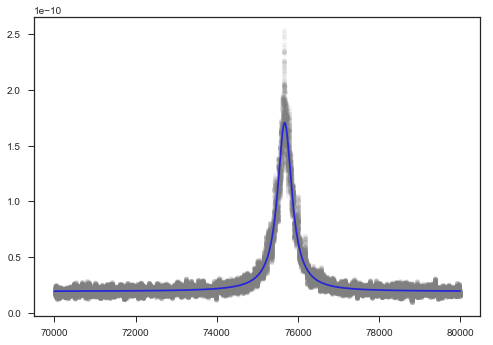

In [10]:
fig_1, ax_1 = plt.subplots()
f_start = 70000
f_end = 80000
window_size = 50

i_start = np.where(f_vert > f_start)[0][0]
i_end = np.where(f_vert > f_end)[0][0]

f_vert_ma = f_vert[i_start:i_end]
P_vert_ma = pd.rolling_mean(P_vert[i_start:i_end],window_size)

ax_1.plot(f_vert_ma, P_vert_ma, '.', ms=10,alpha=0.1, color="gray")

popt, pcov = curve_fit(A_SH, f_vert_ma[window_size+10:-window_size-10], 
                       P_vert_ma[window_size+10:-window_size-10], 
                       p0 = [74000,20,1,0])

f_o_fit, Q_fit, A_dc_fit, A_o_fit = popt
print "Fitted values are: f=%.3e Hz, Q=%.2f, A_DC=%.3e V/Hz^(0.5)" %(popt[0], popt[1], popt[2])

ax_1.plot(f_vert_ma[::3], A_SH(f_vert_ma[::3], f_o_fit, Q_fit, A_dc_fit, A_o_fit), 
          '-b', alpha=0.7)

Calculate kz, OLSz, Sz using Sader's method. For detailed method, see:

Wagner, Cheng, Vezenov. Langmuir 2011, 27, 4635

In [11]:
T = 298
KT = 1.38*1e-23*T

Re = rho*f_o_fit*b**2/eta
kz_sader = 7.525*rho*b**2*L*Q_fit*f_o_fit**2*gamma_f_i(Re)
OLSz_sader = np.sqrt(np.pi*A_dc_fit**2*Q_fit*f_o_fit/2 * kz_sader/KT)
Sz_sader = kz_sader/OLSz_sader

print 0.834*kz_sader, OLSz_sader, 1/OLSz_sader, Sz_sader #N/m, V/m, m/V, N/V

2.3273055653 8292297.98047 1.2059383326e-07 3.36521222166e-07


Experiment was performed in air. The values fitted using JPK instrument

k = 2.294 N/m, S = 105.27 nm/V, f = 74.52 kHz


Values fitted using our code

k = 2.2169 N/m, S = 94.86 nm/V, f = 74.54 kHz

## Torsional data

[  1.54275870e+05   1.28889241e+04   1.03390887e-09   3.90524442e-06]


/Users/Daniel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


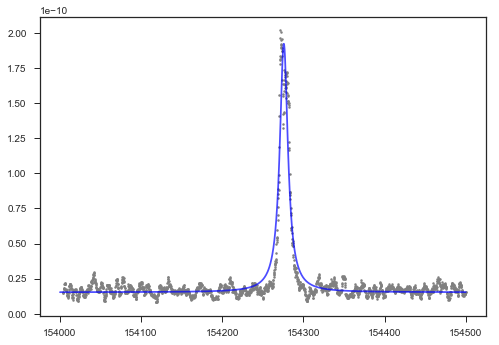

In [12]:
fig_2, ax_2 = plt.subplots()
f_start =154000
f_end = 154500

i_start = np.where(f_lat > f_start)[0][0]
i_end = np.where(f_lat > f_end)[0][0]

window_size = 20 

f_lat_ma = f_lat[i_start:i_end]
P_lat_ma = pd.rolling_mean(P_lat[i_start:i_end],window_size)

ax_2.plot(f_lat_ma, P_lat_ma, '.', ms=5,alpha=1.0, color="gray")

popt, pcov = curve_fit(A_SH, f_lat_ma[window_size+10:-window_size-10], P_lat_ma[window_size+10:-window_size-10], 
                      p0 = [154200,200,1e-8,0])

f_o_fit, Q_fit, A_dc_fit, A_o_fit = popt
print popt

ax_2.plot(f_lat_ma[::3], A_SH(f_lat_ma[::3], f_o_fit, Q_fit, A_dc_fit, A_o_fit), 
          '-b', alpha = 0.7)
fig_2.savefig("fourier.pdf")
# ax_2.set_xlim([120000, 300000])

In [13]:
Re = rho*f_o_fit*b**2/eta

kt_sader = 6.285*rho*b**4*L*Q_fit*f_o_fit**2*gamma_t_i(Re)
OLSt_sader = np.sqrt(np.pi*A_dc_fit**2*Q_fit*f_o_fit/2 * kt_sader/KT)
St_sader = kt_sader/OLSt_sader

print kt_sader, OLSt_sader, St_sader #N m/rad, V/m, N m/V

6.92558682946e-08 237.126532615 2.92062923246e-10


# Summary results

In [14]:
print "Expected flexular spring constant: %.2f to %.2f N/m" %(k_flex_min, k_flex_max)

print "Expected flexular spring constant: %.2f to %.2f nN m" %(k_tor_min, k_tor_max)

print "Ratio expected: %.2e" %(k_tor_max/k_flex_max*1e-9)
print "Ratio expected: %.2e" %(k_tor_min/k_flex_min*1e-9)


print "Experimental flexular spring constant: %.2f N/mm" %kz_sader

print "Experimental torsional spring constant: %.2f nN m" %(kt_sader*1e9)

print "Ratio experimental: %.2e" %(kt_sader/kz_sader)

Expected flexular spring constant: 0.10 to 2.80 N/m
Expected flexular spring constant: 2.80 to 75.71 nN m
Ratio expected: 2.70e-08
Ratio expected: 2.70e-08
Experimental flexular spring constant: 2.79 N/mm
Experimental torsional spring constant: 69.26 nN m
Ratio experimental: 2.48e-08
